In [72]:
import shapefile as shp
import matplotlib.pyplot as plt
import numpy as np

In [73]:
import pandas as pd
import seaborn as sns

df = pd.read_csv('../data/clean_data.csv', index_col='Municipality')
df.drop('missing_count', axis=1, inplace=True)

In [74]:
min_val = df['culture_knowledge_of_catalan_total'].min()
max_val = df['culture_knowledge_of_catalan_total'].max()

In [77]:
import matplotlib

norm = matplotlib.colors.Normalize(vmin=min_val, vmax=max_val)
cmap = matplotlib.cm.get_cmap('Spectral')

(0.9973087274125336, 0.9165705497885429, 0.6090734332948865, 1.0)

In [131]:
shp_path = '../plots/municipalities_map/divisions-administratives-v2r0-municipis-5000-20210701.shp'
sf = shp.Reader(shp_path)

In [150]:
def plot_map(sf, x_lim = None, y_lim = None, figsize = (16,12), data=None):
    '''
    Plot map with lim coordinates
    '''
    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)
    
    # Values
    min_val = data['culture_knowledge_of_catalan_total'].min()
    max_val = data['culture_knowledge_of_catalan_total'].max()
    norm = matplotlib.colors.Normalize(vmin=min_val, vmax=max_val)
    cmap = matplotlib.cm.get_cmap('Spectral')
    
    id=0
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, 'k')
        
        try:
            # Fill
            record = sf.records()[id]
            gid = int(record[0])
            value = df.loc[gid, 'culture_knowledge_of_catalan_total']
            rgba = cmap(norm(value))
            ax.fill(x, y, color=rgba)
            
            # shape_ex = sf.shape(id)
            # x_lon = np.zeros((len(shape_ex.points),1))
            # y_lat = np.zeros((len(shape_ex.points),1))
            # for ip in range(len(shape_ex.points)):
            #     x_lon[ip] = shape_ex.points[ip][0]
            #     y_lat[ip] = shape_ex.points[ip][1]
            # ax.fill(x_lon,y_lat, color)
        except:
            pass
        
        id = id+1
        
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)
    fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)

<Figure size 1152x864 with 0 Axes>

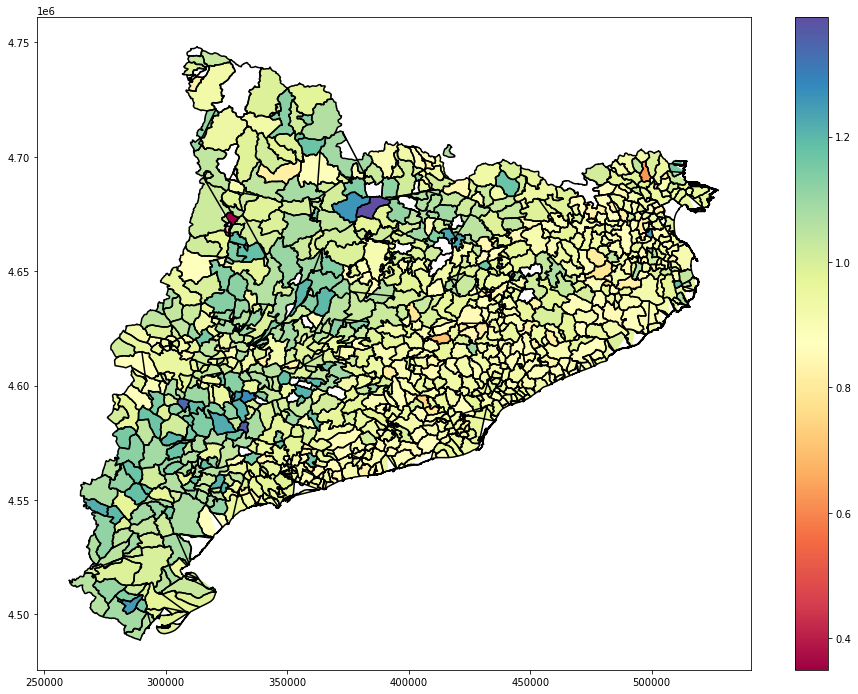

In [151]:
plot_map(sf, data=df)

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

<AxesSubplot:>

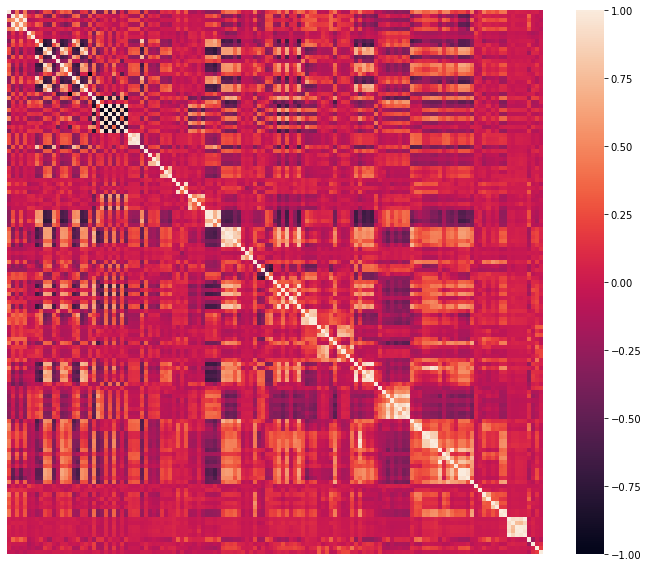

In [22]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(corr, xticklabels=False, yticklabels=False, ax=ax)

In [23]:
# Split label from data
labels = df.filter(like='catalan').columns
df.loc[:, df.columns.isin(labels)].describe()

,culture_knowledge_of_catalan_understand,culture_knowledge_of_catalan_speak,culture_knowledge_of_catalan_read,culture_knowledge_of_catalan_write,culture_knowledge_of_catalan_total
count,962.000000,962.000000,962.000000,962.000000,962.000000
mean,0.948731,0.828282,0.841901,0.626975,0.970596
std,0.099919,0.127554,0.114336,0.104431,0.094880
min,0.345603,0.296524,0.304703,0.208589,0.349693
25%,0.879096,0.739667,0.762628,0.558462,0.908102
50%,0.932393,0.824049,0.832157,0.623925,0.958038
75%,1.006462,0.913404,0.912584,0.688093,1.021242
max,1.390000,1.260000,1.370000,1.021739,1.390000


In [24]:
df = df.loc[:, ~df.columns.isin(labels)]

In [25]:
num_features = df.select_dtypes(include='number').columns
cat_features = df.select_dtypes(exclude='number').columns

In [26]:
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown="ignore")
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features),
    ],
    verbose_feature_names_out=False
)

In [27]:
preprocessed_data = preprocessor.fit_transform(df)
cols = preprocessor.get_feature_names_out()

In [28]:
pca = PCA()
pca_data = pca.fit_transform(preprocessed_data)
exp_var = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var)

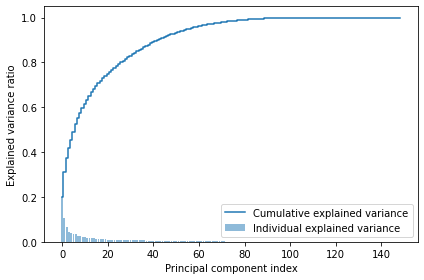

In [29]:
plt.bar(range(0,len(exp_var)), exp_var, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Cumulative explained variance: 0.82


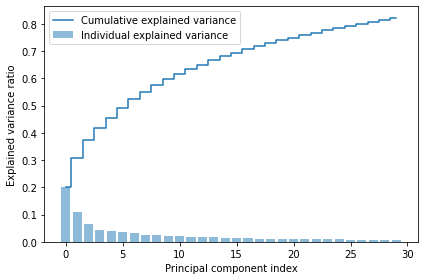

In [31]:
def cumulative_exp_car(components=20):
    exp_var_filtered = exp_var[0:components]
    cum_sum_filtered = cum_sum_eigenvalues[0:components]
    print('Cumulative explained variance:', round(cum_sum_filtered[components-1], 2))
    plt.bar(range(0,len(exp_var_filtered)), exp_var_filtered, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(0,len(cum_sum_filtered)), cum_sum_filtered, where='mid',label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component index')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
cumulative_exp_car()

In [14]:
loadings = pca.components_
num_pc = 30 #pca.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = cols
loadings_df = loadings_df.set_index('variable')
loadings_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
variable,,,,,,,,,,,,,,,,,,,,
territory__altitude,0.104306,0.086519,0.088224,0.070733,-0.045689,0.001816,0.048716,0.101226,-0.098302,-0.095297,-0.087995,-0.006365,-0.049925,-0.035776,0.056963,0.046456,-0.060476,-0.125790,-0.011936,-0.072988
territory__longitude,-0.069375,0.118873,0.013413,-0.079365,-0.140236,0.061307,0.107620,-0.097470,0.160248,-0.073650,-0.052850,0.111057,0.176403,0.136787,-0.120400,-0.028871,-0.024971,0.133496,0.041749,0.123266
territory__latitude,0.031479,0.120105,0.119928,-0.094672,-0.147568,0.051419,0.145954,0.094344,0.051312,-0.146487,-0.107848,0.150214,0.139042,0.071256,-0.037422,-0.078155,-0.039710,0.077499,0.012002,-0.010064
territory__geographic_indicators_utm_coordinates_x_utm_coordinates_x,-0.068733,0.119961,0.014676,-0.079396,-0.141291,0.061693,0.108808,-0.094504,0.159712,-0.075086,-0.053129,0.112104,0.177040,0.136659,-0.119944,-0.028937,-0.025173,0.133039,0.042089,0.122260
territory__geographic_indicators_utm_coordinates_y_utm_coordinates_y,0.033292,0.118439,0.121316,-0.094928,-0.146143,0.050519,0.145247,0.096590,0.048707,-0.146186,-0.108143,0.149700,0.137073,0.069421,-0.035707,-0.079318,-0.039505,0.076362,0.010733,-0.012804


In [15]:
def top_dimensions(df, n=10):
    import pandas as pd
    
    top_df = pd.DataFrame()
    for col in df.columns:
        vars_ix = df.loc[:, col].apply(lambda x: abs(x)).sort_values(ascending=False)[0:n].index
        new_col = df.loc[vars_ix, col].sort_values(ascending=False).reset_index().apply(lambda x : '{} ({})'.format(x[0],x[1]), axis=1)
        top_df = pd.concat([top_df, pd.DataFrame(new_col, columns=[col])], axis=1)
        
    return top_df

In [16]:
pd.set_option('display.max_colwidth', 100)
top_dimensions(loadings_df)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,elections_elections_to_the_european_parliament_electors (0.16842323945548404),labour_affiliations_to_social_security_according_to_contributor_s_residence_affiliations_to_soci...,main_aggregates_urban_property_tax_number_of_receipts (0.19868858198150807),labour_registered_unemployment_by_sectors_by_sectors_services (0.24330845889780825),economic_sectors_fleet_of_vehicles_total (0.28580603743797806),economic_sectors_fleet_of_vehicles_total (0.3064949412606299),economic_sectors_fleet_of_vehicles_estate_cars (0.18676846565464833),economic_sectors_used_agricultural_area_total (0.23965776198754576),economic_sectors_tourist_accommodation_rural_tourism_beds (0.20267838827827986),environment_municipal_waste_generation_per_capita (0.1965276038708339),elections_elections_to_the_congress_of_deputies_turnout (0.25410956927229),population_population_resident_abroad_on_1_january_total (0.27864678144343175),population_deaths_by_sex_women (0.24221995058699705),culture_libraries_total (0.4291396233683977),culture_libraries_total (0.3487646938669183),population_births_by_sex_total (0.4257455498039793),population_deaths_by_sex_total (0.40467958366980705),population_external_immigrations_by_place_of_origin_rest_of_eu (0.22863866128833205),population_external_immigrations_by_place_of_origin_rest_of_eu (0.4469751227685629),environment_industrial_waste_industrial_waste (0.332937008009615)
1,elections_elections_to_the_congress_of_deputies_electors (0.1626751690908375),labour_contributors_to_social_security_according_to_contributors_s_residence_contributors_to_soc...,population_population_by_place_of_birth_abroad (0.18642871122848978),labour_registered_unemployment_by_sectors_registered_unemployment_total (0.23362092828406253),economic_sectors_fleet_of_vehicles_estate_cars (0.2823918346382231),economic_sectors_fleet_of_vehicles_estate_cars (0.30310493623120344),economic_sectors_fleet_of_vehicles_total (0.184384869297217),economic_sectors_used_agricultural_area_permanent_pasture (0.22397956673524536),economic_sectors_tourist_accommodation_rural_tourism (0.19744861928942392),economic_sectors_livestock_ownership_without_livestock (0.18184105905234738),population_density_of_population_density_density (0.2468010821276022),population_population_resident_abroad_on_1_january_men (0.27382932351189204),population_deaths_by_sex_total (0.21903541278373256),culture_libraries_others (0.42481324263892795),population_deaths_by_sex_total (0.27844770896137433),population_births_by_sex_boys (0.3530462462613642),population_deaths_by_sex_women (0.32636358846098146),population_marriages_marriages_total (0.18073438888198498),population_external_migrations_external_immigrations_immigrations (0.39069733250697397),population_marriages_marriages_total (0.281285915560208)
2,population_men_population_from_65_to_84_years (0.15888801299529776),education_level_of_education_attained_higher_education (0.19378259657138278),quality_of_life_type_of_dwellings_total (0.18408248688130996),labour_registered_unemployment_by_sex_registered_unemployment_total (0.2336113615194636),economic_sectors_fleet_of_vehicles_others (0.2799676450244344),economic_sectors_fleet_of_vehicles_industrial_vehicles (0.3003201415732942),economic_sectors_fleet_of_vehicles_motorcycles (0.17295072843655038),economic_sectors_livestock_ownership_with_livestock (0.21208616096545146),economic_sectors_livestock_ownership_with_livestock (0.19380038212967793),economic_sectors_cultivated_land_total (0.17580069887464134),population_population_by_sex_total (0.2173412944617225),population_population_resident_abroad_on_1_january_women (0.26118187124861075),population_internal_migrations_destination_origin_balances_internal_migratory_net_balance (0.192...,culture_libraries_public (0.21394927311538586),culture_libraries_public (0.2771241924758569),population_births_by_sex_girls (0.2716484237142383),population_deaths_by_sex_men (0.2883153810

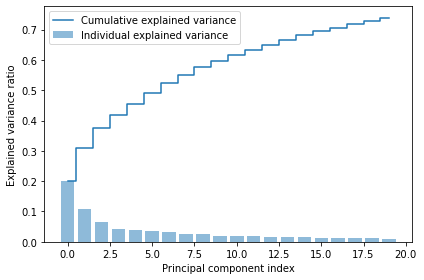

In [34]:
pca = PCA(20)
pca_data = pca.fit_transform(preprocessed_data)
exp_var = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var)

plt.bar(range(0,len(exp_var)), exp_var, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Clustering

### KMeans

In [18]:
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score

index= pd.MultiIndex.from_arrays([['kmeans'], [3]], names=('model', 'K'))
results_df = pd.DataFrame(index=index, columns=['CH score', 'Silhouette score', 'DB score'])

def compute_clustering_and_plot(K, data, results, method='kmeans'):
    # Train the model
    if method == 'kmeans':
        cluster = KMeans(n_clusters=K, max_iter=100)
        cluster.fit(data);
    elif method == 'spectral':
        cluster = SpectralClustering(n_clusters=K)
        cluster.fit(data);
    else:
        return 'Method not recognized'
    
    data['cluster_labels'] = cluster.labels_
    
    # Plot results
    # sns.scatterplot(x='X', 
    #            y='Y',
    #            hue='cluster_labels', 
    #            data=data);
    # plt.plot(cluster.cluster_centers_[:,0], 
    #      cluster.cluster_centers_[:,1], 
    #      'bo', markersize=12,alpha=0.7);
    # plt.xlim(plt.ylim());
    
    # plt.title('K Means predictions with K={}'.format(K));
    # plt.show();
    
    # Compute metrics
    CH = calinski_harabasz_score(data, cluster.labels_)
    S = silhouette_score(data, cluster.labels_ )
    DB = davies_bouldin_score(data, cluster.labels_ )
    
    results.loc[(method, K),:] = [CH,S,DB]
    return results

In [35]:
num_pc = pca.n_components_
red_df = pd.DataFrame(data=pca_data, index=df.index, columns=["PC"+str(i) for i in list(range(1, num_pc+1))])
red_df.to_csv('../data/model_data.csv')

In [242]:
for k in range(2,8,2):
    results = compute_clustering_and_plot(k, red_df, results_df, method='spectral')
results_df

/home/enric/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/enric/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/enric/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:369: UserWarning: Exited at iteration 1376 with accuracies 
[3.66149959e-13 5.18237699e-06 1.66781678e-05 1.01870874e-05
 9.92950356e-06]
not reaching the requested tolerance 1e-05.
  _, diffusion_map = lobpcg(
/home/enric/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:366: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  est = KMeans(
/home/enric/miniconda3/envs/ml/lib/pyth

CH score Silhouette score  DB score
model    K                                     
kmeans   3       NaN              NaN       NaN
spectral 2   7.98024         0.556481  0.324677
         4  7.793577         0.535398  0.330729
         6  7.744244         0.515458    1.1636